In [1]:
# Set notebook to use only one GPU
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
from file_functions import *
from models_bachelors import *
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd
from sklearn.metrics import accuracy_score
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt


methods = load_dict_from_hdf5('predictions.h5')

Using TensorFlow backend


Keras Uncertainty will use standalone Keras backend

In [3]:
def get_corrects(Y_true, Y_pred, axis):
    return np.argmax(Y_true, axis=axis) == np.argmax(Y_pred, axis=axis)

'''
Takes as input, a dict of predictions and labels as such:
{'preds': np.ndarray, 'labels': np.ndarray}
'''
def avg_pred_entropy_plots(dataset):
    bin_size = 0.05
    entropy = predictive_uncertainty(dataset['preds'])    # shape: (9,576)
    Y_true = dataset['labels']    # shape: (9,576,4)
    corrects = get_corrects(Y_true, dataset['preds'], axis=-1) # Get corrects across ALL subjects
    entropy_correct = entropy[corrects]
    entropy_wrong = entropy[~corrects]
    # For distribution plots of predictive entropy
    hist_data = [entropy_correct, entropy_wrong]
    group_labels = ['Correct', 'Incorrect']

    # Normalizes AREA UNDER CURVE to sum up to 1. y-axis values are meaningless.
    hist_correct, bins_correct, _ = plt.hist(entropy_correct, bins=20, density=True, alpha=0.5, label='Correct')
    hist_wrong, bins_wrong, _ = plt.hist(entropy_wrong, bins=20, density=True, alpha=0.5, label='Wrong')
    plt.legend()
    plt.show()

    # Calculate overlap using histogram intersection
    overlap = np.sum(np.minimum(hist_correct, hist_wrong))

    # Normalize overlap between 0 and 1
    normalized_overlap = overlap / np.sum(hist_correct)

    print("Overlap:", normalized_overlap)

'''
Get accuracies for each subject and ret as list
'''
def get_accuracies(data):
    acc = []
    y_preds = data["preds"].argmax(axis=-1)
    y_trues = data["labels"].argmax(axis=-1)
    # Get accuracy of each subject
    for idx, subject in enumerate(y_trues):
        score = accuracy_score(y_pred=subject, y_true=y_preds[idx], normalize=True)
        acc.append(score)
    
    return acc

# Results Analysis

Analyse results


# Rejection use case
Makes no sense to use the interpretability usecase for motor imagery data. Maybe it might be useful for determining how parts of a sample contribute to uncertainty and final output.
Make the following graphs:
- Distribution of Average normalised predictive entropy for incorrect and correct predictions per test subject and lockbox per method. 
- Accuracy confidence plots for both methods on test and lockbox set.

### Accuracy of each method

In [16]:
for name, method in methods.items():
    print(f'{name}')
    np.set_printoptions(precision=3)
    acc_list = get_accuracies(method["test"])   # Get test set accuracies
    print(f'test set avg acc: {round(np.mean(acc_list), 3)}')
    acc_list = get_accuracies(method["lockbox"])
    print(f'lockbox set avg acc: {round(np.mean(acc_list), 3)}\n')

mcdropconnect
test set avg acc: 0.517
lockbox set avg acc: 0.675

mcdropout
test set avg acc: 0.554
lockbox set avg acc: 0.668

standard
test set avg acc: 0.548
lockbox set avg acc: 0.648



### Average normalised predictive entropy

And associated normalised intersection for comparison [0, 1]


mcdropconnect test set


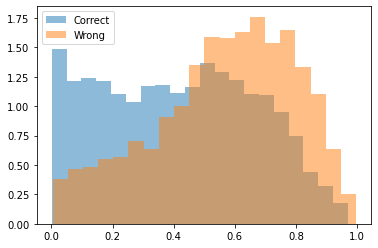

Overlap: 0.7547453367744377
lockbox


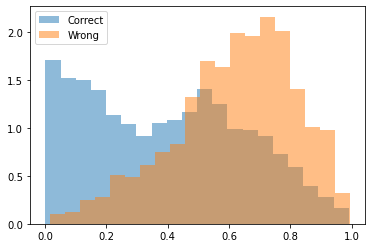

Overlap: 0.6330030005775519
mcdropout test set


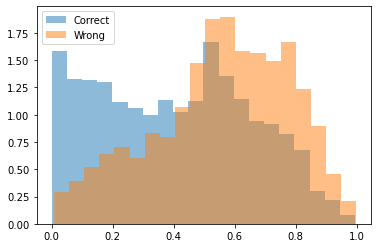

Overlap: 0.7488859985001224
lockbox


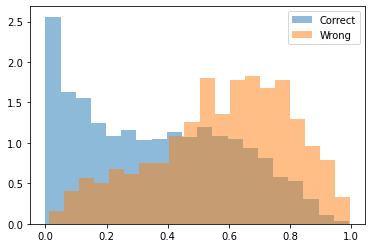

Overlap: 0.6554010643702726
standard test set


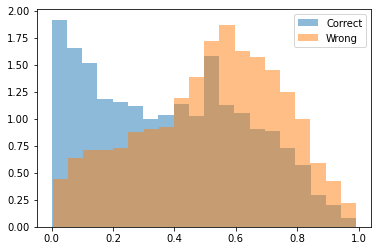

Overlap: 0.7699095559063164
lockbox


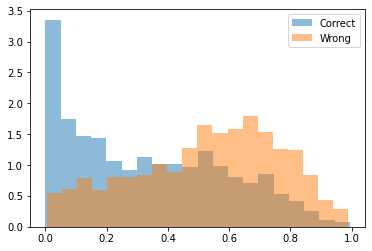

Overlap: 0.687818816110791


In [17]:
for name, method in methods.items():
    print(f'{name} test set')
    avg_pred_entropy_plots(method['test'])
    print(f'lockbox')
    avg_pred_entropy_plots(method['lockbox'])

### Accuracy-coverage plots
These plots are to select a threshold for treating uncertainty as a binary classification task. Once the threshold is selected from the plot, you can compute the uncertainty accuracy, precision, sensitivity, specificity ROC plots and AUROC.

So accuracy and coverage will be computed for predictions that are above a certain uncertainty threshold

Explanations for very poor entropy based accuracy-coverage plots:
Because of high inter-subject variability, the specific model is unable to fully learn subject-independent features, leading to a high degree of epistemic uncertainty (my theory). Maybe I can confirm this by disentangling uncertainty... 

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

dataset_key = 'test'
flag = 'probability'

thresholds = np.arange(0, 1.001, 0.001)
isEntropy = True
if flag == 'probability':
    isEntropy = False

for name, method in methods.items():
    accs = []
    coverages = []
    y_pred = np.vstack(method[dataset_key]['preds'])
    y_true = np.vstack(method[dataset_key]['labels'])
    if isEntropy:
        unc = predictive_uncertainty(y_pred)
    for t in thresholds:
        if isEntropy:
            accepted_idx = (unc < t)           # Accept samples when uncertainty is BELOW threshold
        else:
            accepted_idx = y_pred.max(axis=1) > t           # Accept when predicted prob is ABOVE threshold
        coverages.append(sum(accepted_idx) / y_pred.shape[0])                           # Coverage: How many samples rejected
        acc = accuracy_score(y_pred=y_pred.argmax(axis=1)[accepted_idx], y_true=y_true.argmax(axis=1)[accepted_idx])  # Accuracy of accepted samples
        accs.append(acc)

    if isEntropy:
        coverages = np.flip(np.array(coverages))  # Flip for entropy threshold
        accs = np.flip(np.array(accs))
    else:
        coverages = np.array(coverages)
        accs = np.array(accs)

    plt.plot(thresholds, accs, color='red', label='accs')
    plt.plot(thresholds, coverages, color='green', label='coverage')

    plt.title('Coverage and Accuracy vs Threshold')
    plt.legend()
    # plt.savefig('threshold_plots.png')
    plt.show()

    # Finding equivalent threshold value
    point = np.hstack(np.argwhere(accs > coverages))
    print(f'threshold value for {name}: {point[0] * 0.001}\n acc at threshold: {accs[point[0]]}\n coverage at threshold: {coverages[point[0]]}')



# ROC plots

mcdropconnect: 0.7476512646203973
mcdropout: 0.7390167460612107
standard: 0.7103795322349503


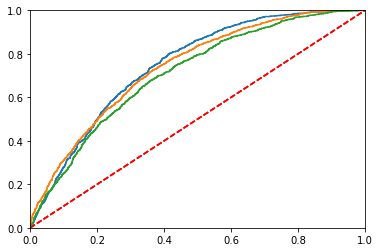

In [6]:
from sklearn import metrics

'''
ic, iu, cc, cu
incorrect-certain, incorrect-uncertain, correct-certain, correct-uncertain


y_true for ROC should be certain if predicted class equals actual class and uncertain otherwise. Should be of shape (n_samples,) and binary labels
y_pred for ROC should be just entropies?
(normalised_entropy, 1-normalised_entropy)

UQ classification: 1->Uncertain     0->Certain
'''

#  np.argmax(Y_true, axis=axis) == np.argmax(Y_pred, axis=axis)


for method, values in methods.items():
    y_true = values['lockbox']['labels']
    y_pred = predictive_uncertainty(values['lockbox']['preds']).flatten()
    # Iterate through entropies and create a new np array of entropies
    # (9*576, 2)

    # Gets corrects across all subjects as ints. 1: incorrect 0: correct
    y_true_roc = (~get_corrects(y_true, values['lockbox']['preds'], axis=-1)).astype(int).flatten()

    fpr, tpr, _ = metrics.roc_curve(y_true_roc,  y_pred)
    auc = metrics.roc_auc_score(y_true_roc, y_pred)
    print(f'{method}: {auc}')
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])

plt.show()


# Disentangling uncertainty